# Assignment 3 - Quantum Communication 

### <span style="color:#61c2e8">Task 3</span>: Quantum Teleportation with Postselection (IonQ)
Now, let's see how to implement teleportation protocol on IonQ system. IonQ devices do not support mid-circuit measurements (that is, they don't have the ability to apply gates based on measurement results). This means that we cannot implement the receiver's part of teleportation protocol.

Instead, we can implement a different scheme which will still allow us to teleport states, at a cost of doing that probabilistically, with success rate of 25%. In this scheme, the sender will perform their part of the protocol as usual, but the receiver will not apply any fixup to the state they receive. Instead, they will discard any runs in which sender's measurement results are anything other than $|00\rangle$.

Unfortunately, the inability to perform mid-circuit measurements will limit the receiver's ability to use the teleported states. Since we cannot analyze the measurement results while running the circuit, we won't know which teleportation runs succeeded. Therefore, there is no way to use this teleportation scheme as a building block of some larger protocol. What we will do to show that teleportation is happening is perform measurement on every qubit and then analyze the measurement data.

#### Run these cells before beginning to import necessary packages.
This cell may take a minute or more to complete. Importing qsharp triggers a sequence of actions which allow us to compile and run Q# code in this notebook.

In [1]:
import qsharp
import qsharp.azure
import matplotlib.pyplot as plt
from collections import defaultdict

Preparing Q# environment...
..

In [2]:
%%qsharp
open Microsoft.Quantum.Diagnostics; 
open Microsoft.Quantum.Measurement;
open Microsoft.Quantum.Canon;
open Microsoft.Quantum.Arrays;
open Microsoft.Quantum.Random;


First let us define the operations `BellStatePrep`, `StatePrepare` and `Sender`. These operations are identical to the ones defined in Task 2. 

In [3]:
%%qsharp
/// # Summary
/// Prepares a Bell state on a 2 qubit array
///
/// # Input
/// ## qs
/// The array that is being acted on

operation BellStatePrep(qs : Qubit[]) : Unit {
    H(qs[0]);
    CNOT(qs[0], qs[1]);
}

/// # Summary
/// Takes a qubit and applies an Ry to it.
///
/// # Input
/// ## q
/// The input qubit

operation StatePrepare(q : Qubit) : Unit is Adj {
    Ry(3.1415 / 7.0, q);
}

/// # Summary
/// In this operation the sender will take her half of the Bell state
/// and entangle it with the qubit she wishes to teleport. 
/// Lastly she will perform Bell state measurement.
/// 
/// # Input
/// ## q
/// The sender's qubit from the initial shared Bell state.
///
/// # Output
/// A tuple of two Results, one for each result in the Bell state measurement.

operation Sender(q : Qubit) : (Result, Result) {
    use qSend = Qubit();
    // Prepare the state to transmit
    StatePrepare(qSend);
    
    // Perform Bell state measurement 
    CNOT(qSend, q);
    H(qSend);
    return (M(qSend), M(q));
}

Lastly we will define a Teleport operation which orchestrates things.

We want to see that the state we teleported was moved onto the receiver's qubit. This state should be the state created by applying the `PrepareState` operation. Therefore, applying the inverse, or adjoint, of this operation should take that state back to $|0\rangle$. In this operation we will apply the adjoint of `PrepareState` to the receiver's qubit at the end of teleportation, if we measure $|0\rangle$ we know that the state was teleported.

In this situation there is no need to define the `Receiver` operation, since the receiver is not applying any transformations and is instead just measuring their qubit.

In [4]:
%%qsharp
/// # Summary 
/// This is the top-level operation for the teleportation routine.
/// It allocates qubits and prepares the initial Bell pair which the sender 
/// and receiver will share, and then performs the teleportation protocol.
///
/// # Output
/// Result array which contains three values:
/// 1, 2 - These are the results of the sender's Bell state measurement.
/// 3 - This is the result of measurement on the receiver's qubit.

operation Teleport() : Result[] {
    use senderQubit = Qubit();
    use receiverQubit = Qubit();
    BellStatePrep([senderQubit, receiverQubit]); 

    // Now the sender performs Bell state measurement.
    let (m1, m2) = Sender(senderQubit);

    // At this point the receiver should perform the post-selection step.
    // However, this cannot be done on IonQ targets.
    // So instead we apply the adjoint of the StatePrepare operation.
    // If we teleport the state properly, we will always measure |0⟩,
    // otherwise we'll measure |1⟩ part of the time.
    // So, when m1 and m2 are |0⟩, we expect to always measure |0⟩.

    Adjoint StatePrepare(receiverQubit);
    return [m1, m2, M(receiverQubit)];
}

Now let's submit this job to the IonQ simulator and see what the histogram looks like. The IonQ simulator has the same constraints as the IonQ hardware, so we will use it to demonstrate the behavior of the protocol.

In [5]:
qsharp.azure.connect(
   resourceId="/subscriptions/476fe4b3-6f35-4af3-8050-b3b41a795058/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/IntroToQuantumProj",
   location="East US")
qsharp.azure.target("ionq.simulator")

Connecting to Azure Quantum...

Authenticated using Microsoft.Azure.Quantum.Authentication.TokenFileCredential


Connected to Azure Quantum workspace IntroToQuantumProj in location eastus.
Loading package Microsoft.Quantum.Providers.IonQ and dependencies...
Active target is now ionq.simulator


{'id': 'ionq.simulator', 'current_availability': {}, 'average_queue_time': 5}

Now submit the job.

In [6]:
job = qsharp.azure.submit(Teleport, shots=500, jobName="Teleportation Post Select")

Submitting Teleport to target ionq.simulator...
Job successfully submitted.
   Job name: Teleportation Post Select
   Job ID: 7b7f1580-18da-4a87-ac31-ef3cd343ac5d


Now check the status of the job. Once it is finished, you can run the results analysis code.

In [7]:
qsharp.azure.status()

{'id': '7b7f1580-18da-4a87-ac31-ef3cd343ac5d', 'name': 'Teleportation Post Select', 'status': 'Succeeded', 'uri': 'https://portal.azure.com/#@microsoft.onmicrosoft.com/resource/subscriptions/476fe4b3-6f35-4af3-8050-b3b41a795058/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/IntroToQuantumProj/job_management?microsoft_azure_quantum_jobid=7b7f1580-18da-4a87-ac31-ef3cd343ac5d', 'provider': 'ionq', 'target': 'ionq.simulator', 'creation_time': '2022-12-10T06:41:58.8887088+00:00', 'begin_execution_time': '2022-12-10T06:42:03.923+00:00', 'end_execution_time': '2022-12-10T06:42:03.942+00:00', 'cost_estimate': '$0.00'}

Plot the results.

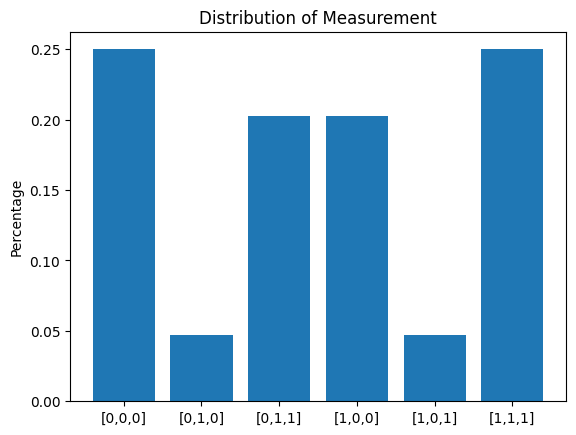

In [8]:
results = defaultdict(float, qsharp.azure.output())
plt.bar(list(results.keys()), list(results.values()))
plt.ylabel("Percentage")
plt.title("Distribution of Measurement")
plt.show()

This is the distribution of the raw measurement results. We want to select only the outcomes where the sender measured $|00\rangle$, since they are the ones in which teleportation yielded the correct state. Let's do that now.

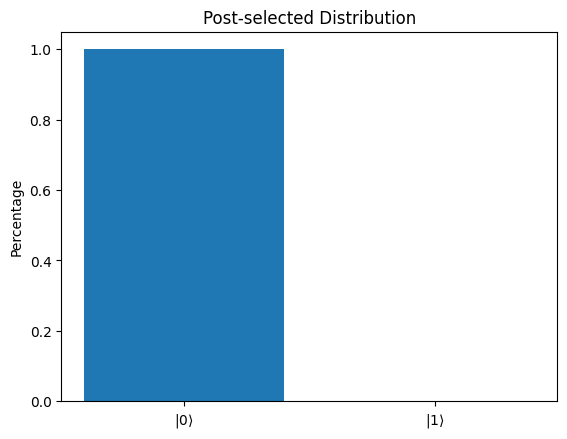

In [9]:
freq0 = results["[0,0,0]"]
freq1 = results["[0,0,1]"]
# Renormalize them 
normFactor = freq0 + freq1
freq0 = freq0/normFactor
freq1 = freq1/normFactor

plt.bar([r"$|0\rangle$", r"$|1\rangle$"], [freq0, freq1])
plt.ylabel("Percentage")
plt.title("Post-selected Distribution")
plt.show()

We only measured $|0\rangle$! Since we were applying the adjoint of `PrepareState` operation to the receiver's qubit, this is what we were hoping for. This means that we are indeed teleporting the state correctly 25% of the time!

### <span style="color:#61c2e8">Task 3 Questions</span>:

* T3.1. We cannot perform mid-circuit measurement on the IonQ platform. Explain why performing mid-circuit measurement can be difficult to implement physically. 

* T3.2. Do you think 25% is the best that can be achieved in any system limited to end-circuit measurements? Justify your answer.

* T3.3. In the measurement results distribution above, the state [0, 0, 1] does not appear, as expected. However, the state [1, 1, 0] also does not appear. Why is this happening?



##### T 3.1

Performing mid-circuit measurements physically changes the behavior of the quantum state.

##### T 3.2

In the system limited to end-circuit measurements, the reciever only measures the state $\ket{00}$ and discards everything else. Therefore, $25\%$ is the best that can be achieved in end-circuit measurements systems. Alternately, the sender can send the states $\ket{0}$ or the state $\ket{1}$ and the reciever can measure the state $\ket{0}$ or the state $\ket{1}$. Therefore, the frequency of the sender sending the state $\ket{0}$ and the reciever measuing the state $\ket{0}$ is $25\%$.

##### T 3.3

For the states $\ket{00}$ and $\ket{11}$, the teleportation is successful. When the teleportation is successful the reciever state is deterministically at $\ket{0}$ or $\ket{1}$, respectively. However, when the teleportation is not successful the measurment is probabilistic, and therefore can be at state $\ket{0}$ or state $\ket{1}$. Therefore, the states $[0,0,1]$ and $[1,1,0]$ do not appear.

You can now continue on to part 4 where we will be exploring quantum repeaters networks.